In [ ]:
import statsapi
import pandas as pd


SyntaxError: invalid syntax (2244088078.py, line 3)

## Preprocessing

In [30]:
players = pd.read_csv("mlb_players_2021.csv")
pitches = pd.read_csv("regseason.csv")

In [31]:
players.rename(columns={"id" : "batter","fullName" : "batter_fullName" , "birthCountry" : "batter_birthCountry"}, inplace=True)
players.head()

,batter,batter_fullName,birthDate,batter_birthCountry,height,weight,primaryPosition,batSide,pitchHand,debutDate,active
0,642758,Domingo Acevedo,1994-03-06,Dominican Republic,"6' 7""",240,P,R,R,2021-06-21,True
1,664119,Austin Allen,1994-01-16,USA,"6' 1""",219,C,L,R,2019-05-11,False
2,462101,Elvis Andrus,1988-08-26,Venezuela,"6' 0""",210,SS,R,R,2009-04-06,False
3,642456,Luis Barrera,1995-11-15,Dominican Republic,"6' 0""",195,OF,L,L,2021-05-19,True
4,605135,Chris Bassitt,1989-02-22,USA,"6' 5""",217,P,R,R,2014-08-30,True


In [32]:
# Merge pitches df with info about the batter
full_df = pd.merge(pitches, players[["batter","batter_fullName","batSide", "batter_birthCountry"]], on="batter")
full_df.head()

,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,count,PBhand,pitch_cat,batter_fullName,batSide,batter_birthCountry
0,1,SL,2021-10-03,85.1,2.39,6.05,"Detmers, Reid",641487,672282,single,...,Standard,293.0,0.079,0.780,0_1,bLpL,breaking,J.P. Crawford,L,USA
1,2,FF,2021-10-03,93.8,2.31,6.03,"Detmers, Reid",641487,672282,NaN,...,Standard,150.0,0.000,-0.045,0_0,bLpL,fastball,J.P. Crawford,L,USA
2,3,CU,2021-10-03,73.9,2.12,6.25,"Detmers, Reid",664238,672282,strikeout,...,Standard,329.0,-0.032,-0.315,2_2,bRpL,breaking,Dylan Moore,R,USA
3,4,FF,2021-10-03,94.6,2.43,5.96,"Detmers, Reid",664238,672282,NaN,...,Standard,146.0,0.000,0.047,1_2,bRpL,fastball,Dylan Moore,R,USA
4,5,FF,2021-10-03,94.3,2.08,6.15,"Detmers, Reid",664238,672282,NaN,...,Standard,151.0,0.000,0.000,1_2,bRpL,fastball,Dylan Moore,R,USA


In [34]:
# Remove the pitches that were fouled, in play, or swung at
not_hit = ["called_strike", "ball"]
pitches_not_hit = full_df[full_df['description'].isin(not_hit)].copy()
len(pitches_not_hit)
pitches_not_hit.head()

,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,count,PBhand,pitch_cat,batter_fullName,batSide,batter_birthCountry
2,3,CU,2021-10-03,73.9,2.12,6.25,"Detmers, Reid",664238,672282,strikeout,...,Standard,329.0,-0.032,-0.315,2_2,bRpL,breaking,Dylan Moore,R,USA
3,4,FF,2021-10-03,94.6,2.43,5.96,"Detmers, Reid",664238,672282,NaN,...,Standard,146.0,0.000,0.047,1_2,bRpL,fastball,Dylan Moore,R,USA
6,7,FF,2021-10-03,94.2,2.33,5.94,"Detmers, Reid",664238,672282,NaN,...,Standard,145.0,0.000,0.032,0_1,bRpL,fastball,Dylan Moore,R,USA
9,10,CU,2021-10-03,73.9,2.22,6.23,"Detmers, Reid",663728,672282,NaN,...,Standard,322.0,0.000,0.174,2_2,bRpL,breaking,Cal Raleigh,S,USA
12,13,FF,2021-10-03,94.4,2.48,5.97,"Detmers, Reid",663728,672282,NaN,...,Standard,148.0,0.000,0.062,1_2,bRpL,fastball,Cal Raleigh,S,USA


In [35]:
pitches_not_hit["strike_zone"] = pitches_not_hit["zone"] <= 9 # Determine if the pitch was actually in the zone

pitches_not_hit["called_correctly"] = (
    ((pitches_not_hit["zone"] <= 9) & (pitches_not_hit["type"] == "S")) | # Pitch is in the zone and is called a strike  
    ((pitches_not_hit["zone"] > 9) & (pitches_not_hit["type"] == "B"))    # Pitch is not in the zone and is called a ball
) 
pitches_not_hit["called_correctly"] = pitches_not_hit["called_correctly"].astype(int) # This will be are target variable -- whether the pitch was called "correctly"

## New addition

In [37]:
from sklearn.model_selection import train_test_split

# Creating a new variable to see if a game altering event (out or man on base) came as a result of the pitch
pitches_not_hit['has_event'] = pitches_not_hit['events'].notna().astype(int) 
y = pitches_not_hit["called_correctly"]
X= pitches_not_hit.drop(["called_correctly"], axis= 1)

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.head()

,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,delta_home_win_exp,delta_run_exp,count,PBhand,pitch_cat,batter_fullName,batSide,batter_birthCountry,strike_zone,has_event
189775,170271,FF,2021-08-13,94.7,-2.22,5.64,"Heuer, Codi",666200,676051,walk,...,0.0,0.171,3_0,bLpR,fastball,Jesús Luzardo,L,Peru,False,1
413477,370222,FF,2021-04-11,92.8,-3.22,5.74,"Scherzer, Max",605131,453286,NaN,...,0.0,-0.045,0_0,bRpR,fastball,Austin Barnes,R,USA,True,0
682964,611987,CH,2021-08-27,88.9,-1.72,5.97,"Manning, Matt",641943,666159,NaN,...,0.0,-0.024,0_1,bLpR,offspeed,Joshua Palacios,L,USA,False,0
578510,518095,FF,2021-08-19,94.4,-2.01,5.68,"Santillan, Tony",605119,663574,NaN,...,0.0,-0.049,1_0,bRpR,fastball,Brian Anderson,R,USA,True,0
686048,614739,FF,2021-08-05,97.2,-1.22,5.71,"Funkhouser, Kyle",608700,608335,NaN,...,0.0,0.014,0_1,bRpR,fastball,Kevin Plawecki,R,USA,False,0


In [38]:
all_quant_cols = [  # only numerical features
    'release_speed', 'release_pos_x', 'release_pos_z', 'zone', 'balls', 'strikes',
    'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'outs_when_up', 'inning',
    'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate', 'release_extension',
    'release_pos_y', 'woba_value', 'woba_denom', 'babip_value', 'iso_value',
    'at_bat_number', 'pitch_number', 'home_score', 'away_score', 'bat_score',
    'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score',
    'post_fld_score', 'spin_axis', 'delta_home_win_exp', 'delta_run_exp', 'has_event'
]

all_qual_cols = [
    'pitch_type', 'game_date', 'player_name', 'events', 'description', 'des', 'game_type',
 'stand', 'p_throws', 'home_team', 'away_team', 'type', 'inning_topbot', 'pitch_name',
 'if_fielding_alignment', 'of_fielding_alignment', 'count', 'PBhand', 'pitch_cat', 
 'batter_fullName', 'batSide', 'batter_birthCountry', 'strike_zone'
]

def encode_categoricals(df, categorical_cols):
    return pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [68]:
unique_woba_denom = X_test['woba_value'].dropna().unique()

# Print the unique values
print(unique_woba_denom)

[0.  0.7]


In [41]:

from itertools import combinations
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

best_score = 0
best_cols = []

min_datapoints = 500
# Total number of combinations
total_combos = len(all_qual_cols) * len(list(combinations(all_quant_cols, 2)))

# Initialize progress bar
with tqdm(total=total_combos, desc="Evaluating combinations") as pbar:
    for qual in all_qual_cols:
        for pair in combinations(all_quant_cols, 2): 
            cols = list(pair) + [qual]  # use just the current qualitative column
            try:
                # Drop rows with NaNs in selected columns only
                X_sub = X_train[cols].dropna()
                y_sub = y_train.loc[X_sub.index]

                if len(X_sub) > min_datapoints:
                    continue

                LR = LogisticRegression()
                LR.fit(X_sub, y_sub)
                score = LR.score(X_sub, y_sub)

                if score > best_score:
                    best_score = score
                    best_cols = cols
                    print(f"\n✅ New best score: {best_score:.4f} with features: {best_cols}")
            except KeyError:
                pass
            except ValueError:
                pass
            finally:
                pbar.update(1)

Evaluating combinations:  70%|██████▉   | 11857/17043 [08:10<10:29,  8.24it/s]


✅ New best score: 0.9179 with features: ['release_speed', 'release_pos_x', 'count']


Evaluating combinations:  70%|██████▉   | 11895/17043 [08:22<27:05,  3.17it/s]


✅ New best score: 0.9179 with features: ['release_pos_x', 'release_pos_z', 'count']


Evaluating combinations:  96%|█████████▌| 16326/17043 [14:03<01:46,  6.71it/s]  


✅ New best score: 0.9633 with features: ['release_speed', 'woba_value', 'strike_zone']


Evaluating combinations:  99%|█████████▉| 16837/17043 [15:28<00:34,  5.98it/s]


✅ New best score: 0.9635 with features: ['release_spin_rate', 'woba_value', 'strike_zone']


Evaluating combinations:  99%|█████████▉| 16897/17043 [15:39<00:08, 17.99it/s]


✅ New best score: 0.9684 with features: ['woba_value', 'woba_denom', 'strike_zone']


Evaluating combinations: 100%|██████████| 17043/17043 [15:54<00:00, 17.85it/s]


In [45]:
print(best_cols)
print(best_score)
print(X_train['woba_value'].count())
print(X_train['woba_denom'].count())
print(X_train['strike_zone'].count())

['woba_value', 'woba_denom', 'strike_zone']
0.968421052631579
19380
19380
292716


In [28]:
print(best_cols)
print(best_score)

[]
0


In [52]:
X_test.head()

,woba_value,woba_denom,strike_zone
302738,NaN,NaN,True
144685,NaN,NaN,True
693679,NaN,NaN,False
113273,NaN,NaN,False
113660,NaN,NaN,False


In [59]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Subset to best columns
X_train_best = X_train[best_cols]
X_train_best = X_train[best_cols].dropna()
y_train = y_train.loc[X_train_best.index]
X_test_best = X_test[best_cols]
X_test_best = X_test[best_cols].dropna()
y_test = y_test.loc[X_test_best.index]

# Scale them
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_best)
X_test_scaled = scaler.transform(X_test_best)

# Train model
clf = LogisticRegression()
clf.fit(X_train_scaled, y_train)

# Predict and score
y_pred = clf.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9678


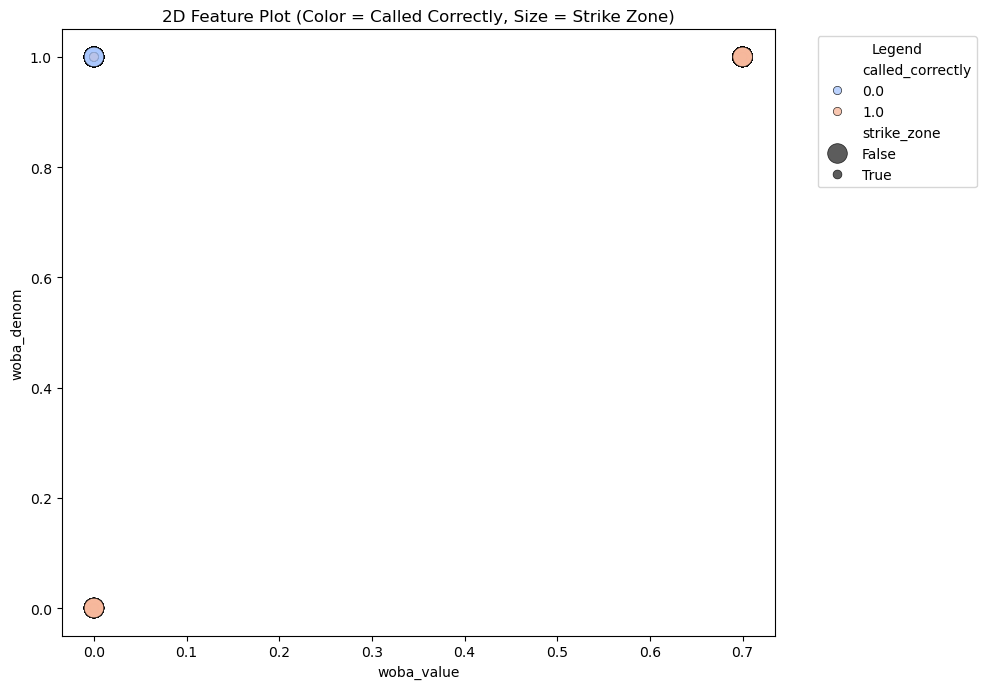

### Takeaways

I created a very accurate model, but it is rather boring. The next step is to understand why this model accuracy is so good and limit our variables